# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 4</span>
 
In this exercise we perform Molecular Dynamics simulations of a Lennard-Jones gas in the microcanonical (NVE) ensemble. The main focus is the analysis of the velocity distribution, which is compared with the theoretical predictions of statistical mechanics.


### Notebook structure

This notebook is organized into the following sections:

- [**Introduction**](#introduction)  
  A general overview of the physical system, the Lennard-Jones interaction, reduced units, and the Molecular Dynamics algorithm used in the simulations.  

- [**POFV and implementation**](#pofv-and-implementation)  
  Definition of the Maxwell–Boltzmann distribution, explanation of how the velocity probability distribution (POFV) is computed in the code, and verification of the implementation using data blocking.  

- [**From Dirac to Maxwell–Boltzmann**](#from-dirac-to-maxwell–boltzmann)  
  Discussion of how the velocity distribution evolves from an initial non-equilibrium state (Dirac delta) towards the Maxwell–Boltzmann distribution as the system equilibrates.  

- [**Reverse time**](#reverse-time)  
  Analysis of time-reversibility in Molecular Dynamics through the Verlet algorithm, highlighting the role of reversibility in conserving energy and sampling the correct ensemble.


# Introduction

## System Description

We simulate a system of $N$ classical particles of mass $m$, confined in a cubic box of side $L$ with **periodic boundary conditions**, in order to mimic bulk behavior and eliminate surface effects.  

The particles interact via the **Lennard-Jones (LJ) potential**:

$$
V_{\text{LJ}}(r) = 4\varepsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^{6} \right],
$$

where:
- $\varepsilon$ sets the energy scale of the interaction,
- $\sigma$ represents the characteristic distance at which the potential changes sign,
- $r$ is the inter-particle distance.

For computational efficiency, the potential is truncated at a cutoff distance $r_c$, and the **minimum image convention** is applied to account only for the closest periodic replica of each particle.

The simulation is performed in the **microcanonical ensemble (NVE)**, where the total number of particles $N$, the volume $V$, and the total energy $E$ are conserved:

$$
N, \; V, \; E \quad \text{fixed}.
$$



### Reduced Units

It is often convenient to introduce **dimensionless reduced units**, defined as:

$$
r^* = \frac{r}{\sigma}, 
\quad
T^* = \frac{k_B T}{\varepsilon}, 
\quad
\rho^* = \rho \sigma^3 = \frac{N}{V}\sigma^3, 
\quad
P^* = \frac{P \sigma^3}{\varepsilon}, 
\quad
V^* = \frac{V}{\varepsilon}.
$$

In these units, the Lennard-Jones potential becomes:

$$
V^*(r^*) = 4 \left[ \left( \frac{1}{r^*} \right)^{12} - \left( \frac{1}{r^*} \right)^{6} \right].
$$

The use of reduced units ensures that different real systems (e.g., Argon, Xenon) can be described by the same dimensionless equations, according to the **law of corresponding states**.

### Integration Algorithm

The time evolution of the system is obtained by integrating **Newton’s equations of motion** using the **Verlet algorithm**:

$$
\mathbf{r}(t+\Delta t) \approx 2 \mathbf{r}(t) - \mathbf{r}(t-\Delta t) + \Delta t^2 \, \mathbf{a}(t),
$$

where $\mathbf{a}(t)$ is the acceleration computed from the inter-particle forces at time t.  

Key features of the Verlet scheme (as discussed in the theory slides):

- **Order $\Delta t^2$ accuracy** (local truncation error).  
- **Time-reversible**: evolving forward and then backward with $-\Delta t$ returns to the initial state.  
- **Good energy conservation** over long trajectories.  
- **Only one force evaluation per step**, making it computationally efficient.  
- Compact in memory (requires only positions at $t$ and $t-\Delta t$).  

Velocities are not directly used in the update, but can be reconstructed from the trajectory as:

$$
\mathbf{v}(t) \approx \frac{\mathbf{r}(t+\Delta t) - \mathbf{r}(t-\Delta t)}{2 \Delta t}.
$$

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# POFV and implementation

In Statistical Mechanics the Maxwell–Boltzmann distribution (<a href="https://en.wikipedia.org/wiki/Maxwell%E2%80%93Boltzmann_distribution" target="_blank">Link Wikipedia</a>) is a probability distribution used for describing particle speeds in idealized gases. However, rarefied gases at ordinary temperatures behave very nearly like an ideal gas and the Maxwell–Boltzmann speed distribution is an excellent approximation for such gases. For a 3D system its formula is:
$$p(v,T) = \left( \frac{m}{2\pi k_B T} \right)^{3/2} 4\pi v^2 e^{-\frac{m v^2}{2 k_B T}}$$

By using LJ reduced units (Lenght: $\sigma$; Energy: $\epsilon$; Mass: the mass, $m$, of the particles; Temperature: $\epsilon/k_B$; velocity: $\sqrt{\epsilon/m}$) its form becomes:
$$p(v^*,T^*) = \frac{1}{(2\pi T^*)^{3/2}} 4\pi (v^*)^2 e^{-\frac{(v^*)^2}{2 T^*}}$$

The NSL_SIMULATOR code already computes the total (internal) energy per particle, $E/N$, the potential energy per particle, $U/N$, the kinetic energy per particle, $K/N$, the temperature, $T$, and the pressure, $P$. I included the calculation of the Maxwell–Boltzmann distribution.


### Implementation in the code

The Maxwell–Boltzmann distribution, $p(v^*,T^*)$, can be approximately computed as a **normalized histogram** on an appropriate interval $\left[ 0, v_{max}\right]$ and chosing the number of bins into which you want to divide this interval.

- **Property setup & binning.** We enabled the `POFV` property in `properties.dat` and set the number of histogram bins. In `initialize_properties()` the code allocates memory, assigns an index to the POFV, and defines the bin width as  
  $$\Delta v = \frac{v_{\max}}{N_{\text{bins}}}, \qquad v_{\max} = k \sqrt{T^*},$$  
  with $k=4$ as a cutoff factor.  

- **Instantaneous histogram.** During each measurement (`measure()`), the speed of every particle is computed as the modulus of its velocity, $v_i=|\mathbf{v}_i|$. The corresponding bin is incremented, and counts are normalized by $(N \, \Delta v)$ so that the histogram approximates a probability density function.  

- **Data blocking & uncertainties.** At the end of each block (`averages()`), the code outputs for every bin: the block average, the progressive average across all completed blocks, and the statistical error (computed with the blocking error formula). Results are written in `OUTPUT/pofv.dat` as:  BLOCK,     VELOCITY,     BLOCK_POFV,     AVE_POFV,     ERROR.


### Verification of the implementation

To check the correctness of the POFV implementation, we performed a Molecular Dynamics simulation with the following input parameters:

- **Temperature:** $T^* = 2$  
- **Number of particles:** $N = 108$  
- **Density:** $\rho^* = 0.05$  
- **Cutoff radius:** $r_c = 5.0$  
- **Time step:** $\Delta t = 0.001$  
- **Number of blocks:** 20  
- **Steps per block:** 2000  
- **Numer of bins:** 30

During the run we measured the velocity distribution $p(v^*)$ and collected it using the data blocking procedure.   
The final progressive averages were compared with the theoretical Maxwell–Boltzmann distribution at $T^* = 2.2$, corresponding to the temperature of the last simulation block. Since temperature is not a conserved quantity in Molecular Dynamics, this choice ensures consistency between the simulated velocity distributions and the appropriate theoretical reference.


In [62]:
data = np.loadtxt("gas/OUTPUT/pofv.dat")


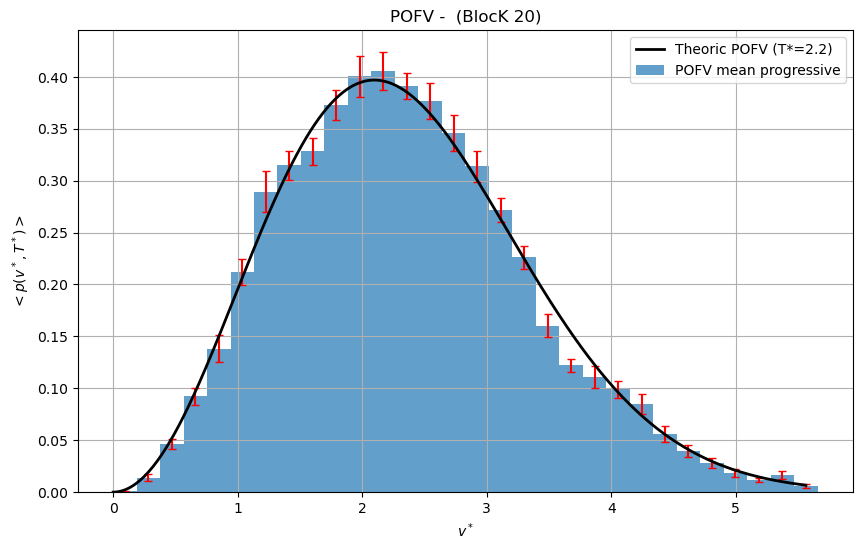

In [63]:
# ultimo blocco
blk_finale = np.max(data[:,0])
data_finale = data[data[:,0] == blk_finale]

v_bin_center = data_finale[:,1]
pofv_prog = data_finale[:,3]
errori = data_finale[:,4]
plt.figure(figsize=(10,6))
plt.bar(v_bin_center, pofv_prog, width=v_bin_center[1] - v_bin_center[0],
        align='center', alpha=0.7, label='POFV mean progressive')
plt.errorbar(v_bin_center, pofv_prog, yerr=errori,
             fmt='none', ecolor='red', capsize=3)

# --- curva teorica Maxwell-Boltzmann ---
T_star = 2.2  # inserisci qui la tua temperatura ridotta-!!!! che deve essere la temperatura a fine simulazione
v = np.linspace(0, max(v_bin_center), 500)
p_theory = (1.0/((2*np.pi*T_star)**1.5)) * 4*np.pi * v**2 * np.exp(-v**2/(2*T_star))
# normalizzazione numerica
dv = v[1]-v[0]
p_theory /= np.sum(p_theory*dv)

plt.plot(v, p_theory, 'k-', lw=2, label=f'Theoric POFV (T*={T_star})')

plt.xlabel("$ v^* $")
plt.ylabel(r"$< p(v^*, T^*) >$")
plt.title(f"POFV -  (BlocK {int(blk_finale)})")
plt.grid(True)
plt.legend()
plt.show()


**Figure 1:** Comparison between the simulated velocity distribution (POFV) at block 20 and the theoretical Maxwell–Boltzmann distribution for $T^*=2$.  
The histogram shows the progressive block averages with error bars, while the solid line represents the analytical prediction.  
The excellent agreement validates the implementation of the POFV measurement in the Molecular Dynamics code.


The comparison shows an excellent agreement: the simulated histogram reproduces the expected functional form (zero at $v^*=0$, peak near $v^* \simeq \sqrt{2T^*}$, and exponential decay in the tail). This confirms the correctness of the implementation.

# From Dirac to Maxwell–Boltzmann

To study the relaxation towards equilibrium, we prepared the system in a very artificial initial condition. 
**Initial conditions**  
   - **Particle positions:** particles are placed on a *fcc crystal* occupying half of the simulation box in each dimension.  
   - **Velocity distribution:** we impose a Dirac–like distribution  
     $$
     p_\delta(v^*,T^*) = \delta\!\left(v^* - v_{T^*}\right),
     $$  
     where $v_{T^*}$ is connected to the reduced temperature $T^*$ via
     $$
     v_{T^*}=\sqrt{3T^*}
     $$ 
     Practically, this is realized by assigning each particle the same speed $v_{T^*}$, with opposite directions paired, so that the total momentum is zero.


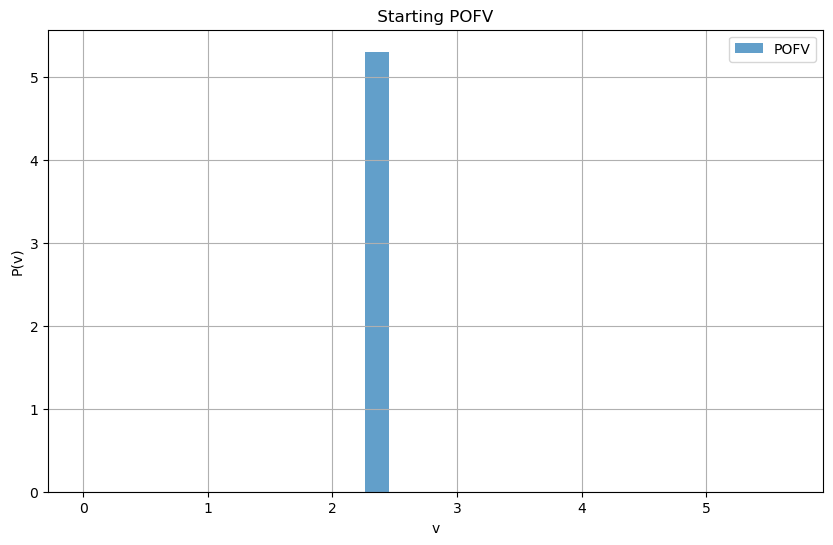

In [64]:
#starting pofv:
start_distrib = np.loadtxt("dirac/OUTPUT/starting_distribution_velocities.dat")
v_bin_center=start_distrib[:,0]
plt.figure(figsize=(10,6))
plt.bar(v_bin_center, start_distrib[:,1], width=v_bin_center[1] - v_bin_center[0], align='center', alpha=0.7, label='POFV')
plt.xlabel("v")
plt.ylabel("P(v)")
plt.title(f" Starting POFV ")
plt.grid(True)
plt.legend()
plt.show()


**Figure 2:** Initial velocity distribution (POFV) obtained by assigning the same speed 
$v_0=\sqrt{3T^*}$ to all particles, with opposite velocities paired two by two.  
This initialization produces a Dirac–like distribution, where all particles share the same 
velocity modulus and the histogram shows a single spike at $v_0$.  


To investigate the relaxation towards equilibrium, I performed a Molecular Dynamics simulation using the input parameters reported above.  
The initial Dirac–like velocity distribution then evolves under the dynamics, and its convergence to the Maxwell–Boltzmann distribution is shown in Figure 3.


In [65]:

import pandas as pd


def maxwell_boltzmann(v, Tstar=1.0):
    """Distribuzione di Maxwell–Boltzmann (moduli velocità, m=kB=1)."""
    return 4*np.pi * (1/(2*np.pi*Tstar))**1.5 * v**2 * np.exp(-v**2/(2*Tstar))

def plot_pofv_blocks(pofv_path, blocks=[1,2,3,10,11,12,18,19,20], Tstar=1.35):
    df = pd.read_csv(pofv_path, delim_whitespace=True, comment="#", header=None,
                     names=["block", "v", "block_avg", "prog_avg", "prog_err"])
    
    fig, axes = plt.subplots(3, 3, figsize=(12, 10))
    axes = axes.ravel()

    for ax, b in zip(axes, blocks):
        dfb = df[df["block"] == b]
        v, y, err = dfb["v"], dfb["prog_avg"], dfb["prog_err"]

        dv = np.mean(np.diff(v))
        ax.bar(v, y, width=dv, alpha=0.6, label=f"Block {b}")
        ax.errorbar(v, y, yerr=err, fmt='.', color='red')

        # Aggiungo MB solo al blocco 20
        if b == 20:
            vfit = np.linspace(0, v.max(), 400)
            yfit = maxwell_boltzmann(vfit, Tstar)
            # normalizzazione al range dei dati
            yfit /= np.trapz(yfit, vfit)#computes the numeric integral of trapezoid 
            ax.plot(vfit, yfit, 'k--', lw=2, label=f"MB fit T*={Tstar:.2f}")

        ax.set_title(f"Block {b}")
        ax.set_xlabel("v*")
        ax.set_ylabel("p(v*)")
        ax.legend(fontsize=8)
        ax.grid(True)

    plt.tight_layout()
    plt.show()


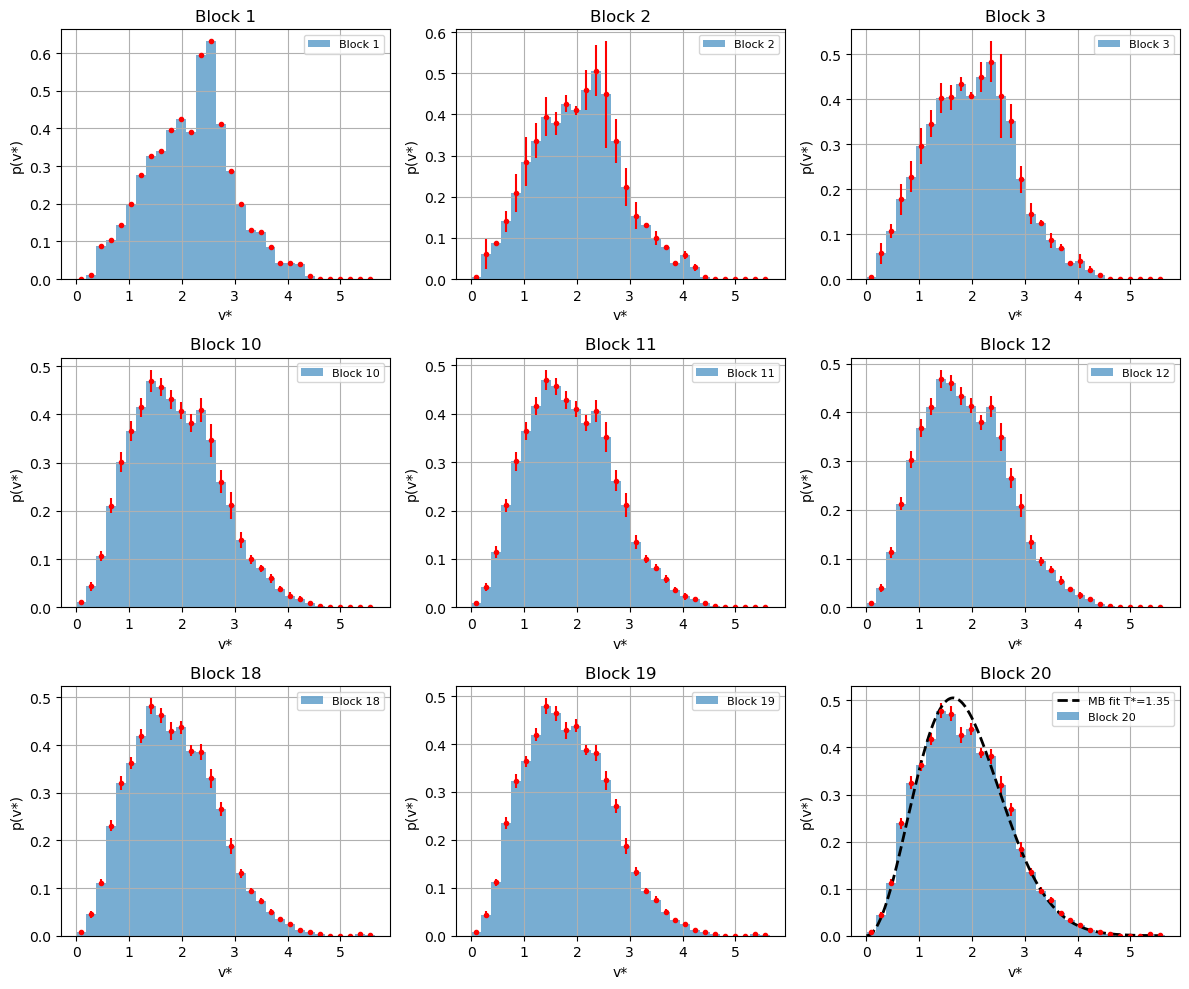

In [66]:
plot_pofv_blocks('dirac/OUTPUT/pofv.dat')

**Figure 3:** Time evolution of the velocity distribution (POFV) starting from the Dirac–like initial condition.  
The histograms show the block–averaged distributions at different simulation blocks (1–3, 10–12, 18–20).  
As the system evolves under Molecular Dynamics in the microcanonical ensemble, the sharp initial spike at $v^* \simeq \sqrt{3T^*}$ progressively broadens and relaxes to the smooth Maxwell–Boltzmann distribution (red line), confirming the equilibration of the system.


 **Entropy and irreversibility**  
   - The evolution corresponds to an **increase in entropy**:  
     - velocities evolve from an ordered and highly correlated state (all particles have the same speed) to a disordered state described by the MB distribution;  
     - positions evolve from a crystal-like arrangement to a more homogeneous configuration in space.  
   - This illustrates the second law of thermodynamics: the system moves towards more probable, higher-entropy states.

 **Reversing time**  
   - If we could reverse all velocities at equilibrium, the system would in principle remain in equilibrium (MB distribution is stationary).  
   - In practice, due to microscopic chaos and numerical precision, exact time reversal is impossible beyond short timescales.  
   - Therefore, the system at equilibrium is statistically time-symmetric, but any perturbation away from equilibrium relaxes irreversibly back to MB.

# Reverse-time


To simulate the reversed dynamics, I exploited the time-reversibility of the Verlet algorithm.  
At the end of the forward MD run the code outputs the last two configurations:
- `config.xyz` → particle positions at the final step $ \mathbf{r}_T $  
- `conf-1.xyz` → particle positions at the penultimate step $ \mathbf{r}_{T-\Delta t} $

Since the Verlet update rule
$$
\mathbf{r}(t+\Delta t) = 2\mathbf{r}(t) - \mathbf{r}(t-\Delta t) + \mathbf{a}(t)\Delta t^2
$$
is symmetric in time, the integration can be reversed by swapping the role of these two files:
- the **current configuration** is set to `conf-1.xyz` ($ \mathbf{r}_{T-\Delta t} $)  
- the **previous configuration** is set to `config.xyz` ($ \mathbf{r}_T $)  

This effectively makes the first step of the new simulation compute $\mathbf{r}_{T-2\Delta t}$, thus evolving the system backwards in time without explicitly inverting the velocities.

Moreover, the file `seed.out` produced during the forward simulation was used as the random seed for the reversed-time run.  
Although no random numbers are needed in the NVE integration itself, this ensures full consistency of the input setup with the forward run.

The simulation was then continued in the NVE ensemble with the same parameters, allowing me to monitor how macroscopic observables (kinetic and potential energy, temperature) behave when the microscopic dynamics is integrated in the reversed time direction.


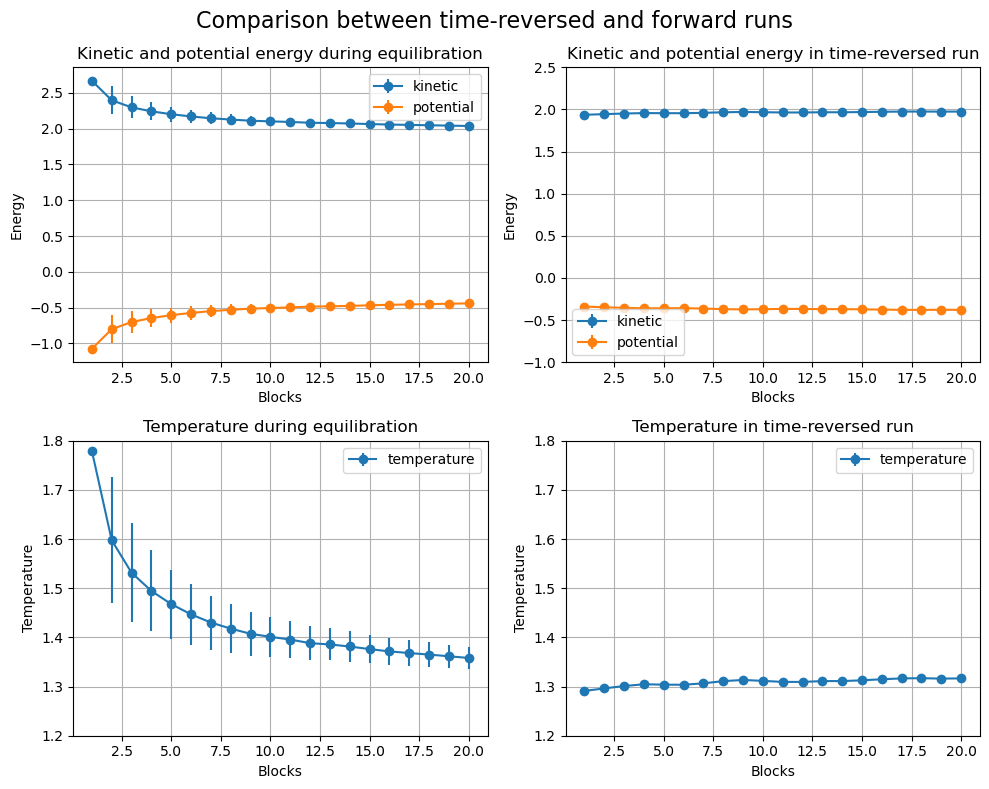

In [67]:
# load equilibration data
block_kin_2, avg_kin_2, err_kin_2 = np.loadtxt("dirac/OUTPUT/kinetic_energy.dat", usecols=(0,2,3), unpack=True)
block_pot_2, avg_pot_2, err_pot_2 = np.loadtxt("dirac/OUTPUT/potential_energy.dat", usecols=(0,2,3), unpack=True)
block_t_2, avg_t_2, err_t_2 = np.loadtxt("dirac/OUTPUT/temperature.dat", usecols=(0,2,3), unpack=True)

# load reversed time data
block_kin_3, avg_kin_3, err_kin_3 = np.loadtxt("reverse/OUTPUT/kinetic_energy.dat", usecols=(0,2,3), unpack=True)
block_pot_3, avg_pot_3, err_pot_3 = np.loadtxt("reverse/OUTPUT/potential_energy.dat", usecols=(0,2,3), unpack=True)
block_t_3, avg_t_3, err_t_3 = np.loadtxt("reverse/OUTPUT/temperature.dat", usecols=(0,2,3), unpack=True)

# create 2x2 figure
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

axs[0,0].errorbar(block_kin_2, avg_kin_2, err_kin_2, label='kinetic', fmt='o-') 
axs[0,0].errorbar(block_pot_2, avg_pot_2, err_pot_2, label='potential', fmt='o-') 
axs[0,0].set_xlabel('Blocks')
axs[0,0].set_ylabel('Energy')
axs[0,0].set_title('Kinetic and potential energy during equilibration')
axs[0,0].legend()
axs[0,0].grid(True)

axs[0,1].errorbar(block_kin_3, avg_kin_3, err_kin_3, label='kinetic', fmt='o-') 
axs[0,1].errorbar(block_pot_3, avg_pot_3, err_pot_3, label='potential', fmt='o-') 
axs[0,1].set_xlabel('Blocks')
axs[0,1].set_ylabel('Energy')
axs[0,1].set_ylim(-1, 2.5)
axs[0,1].set_title('Kinetic and potential energy in time-reversed run')
axs[0,1].legend()
axs[0,1].grid(True)

axs[1,0].errorbar(block_t_2, avg_t_2, err_t_2, label='temperature', fmt='o-')  
axs[1,0].set_xlabel('Blocks')
axs[1,0].set_ylabel('Temperature')
axs[1,0].set_title('Temperature during equilibration')
axs[1,0].set_ylim(1.2, 1.8)
axs[1,0].legend()
axs[1,0].grid(True)

axs[1,1].errorbar(block_t_3, avg_t_3, err_t_3, label='temperature', fmt='o-')  
axs[1,1].set_xlabel('Blocks')
axs[1,1].set_ylabel('Temperature')
axs[1,1].set_title('Temperature in time-reversed run')
axs[1,1].set_ylim(1.2, 1.8)
axs[1,1].legend()
axs[1,1].grid(True)

plt.suptitle('Comparison between time-reversed and forward runs', fontsize=16)
plt.tight_layout()
plt.show()


**Figure 4.** Comparison between forward and time-reversed simulations.  
Top panels: block averages of kinetic and potential energy during the forward equilibration run (left) and the time-reversed run (right).  
Bottom panels: block averages of the temperature in the same two runs. Error bars represent the statistical uncertainty within each block.


  
The reversed simulation confirms that microscopic dynamics with the Verlet algorithm is time-reversible: the macroscopic observables (kinetic and potential energy, temperature) remain stable and consistent with the equilibrium value $T^* \simeq 2.2$.  
This confirms that is not possible to evolve from a high-entropy equilibrium configuration back to the highly ordered, low-entropy state of the initial preparation, because the probability to evolve from equilibrium state to a non equilibrium state is very low.  
This illustrates a key point: while Newton’s equations are reversible in time, the macroscopic evolution of the system is irreversible, and entropy cannot spontaneously decrease.
